# Are the randomized and actual in-strength histograms significantly different?

At the end of investigating randomized strength histograms, we ended up with the plot below, and the question of whether the difference between the two is statistically significant or not:

In [1]:
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
import matplotlib.pyplot as plt

In [2]:
import random
import networkx
graph = networkx.read_edgelist('./word_association_graph_DSF.txt', 
                               create_using=networkx.DiGraph(), 
                               nodetype=str, data=[('weight', float),])

In [3]:
def randomize_edgeweights2(network):
    edge_weights = [attrs['weight'] for source, target, attrs in network.edges(data=True)]
    random.shuffle(edge_weights) # randomizes order, in-place
    graph_randomized = network.copy()
    for (source, target), edge_weight in zip(graph_randomized.edges(), edge_weights):
        graph_randomized[source][target]['weight'] = edge_weight
    return graph_randomized

In [4]:
def in_strengths(network):
    in_strengths = {}
    for node in network.nodes():
        in_strengths[node] = 0
    for source, target, attrs in network.edges(data=True):
        in_strengths[target] += attrs['weight']
    return in_strengths

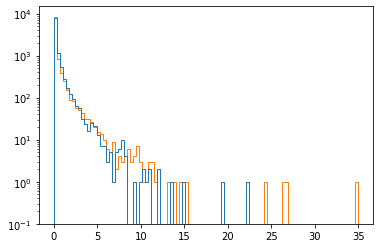

In [5]:
_ = plt.hist([list(in_strengths(randomize_edgeweights2(graph)).values()),
              list(in_strengths(graph).values()),
             ], bins=100, histtype='step', log=True)

We have mentioned above that the actual and the randomized out-strength histograms differ. Do the in-strength histograms differ? Strictly speaking yes, because we can see both colors on the plot, i.e. they don't match the same way the edge weight histograms matched (once we took care not to re-use edge weights during the randomization). But are they different histograms? 

To answer such a question, we essentially have to convert a difference into a probability. I.e. we expect that random noise will cause some small difference with high probability, and cause a large difference with low probability. Given some amount of difference, if we can calculate the probability of such a difference appearing, we can then use that to decide whether such a probability is large or small.

Essentially this is the idea behind calculating $p$-values, where a statement such as "this result is statistically significant at $p\le 0.05$" means that the probability of getting the experimental result just from random noise is lower than $5\%$. (see for example the wikipedia page:  https://en.wikipedia.org/wiki/Statistical_significance )

Unfortunately, running such a statistical test requires doing some statistical calculations. Essentially, we would need to characterise how the in-strength distribution is likely to look like, and then to calculate the probability that the difference between the two histograms is at least as large as that on the plot. Even the first part, calculating a difference between the histograms, to summarize the distance between the two in one single number, might be problematic.

As hinted at in the homework assignment, there is a nice trick that avoid side-stepping all of these complicated questions. All we need to do is exercise the previous reflexes of not accepting a stochastic result from a sample of just one. Re-running the code above to re-generate the plot will give a hint as to whether the difference we see on this plot persists. Even better, we can plot multiple runs on the same plot to compare them to each other:

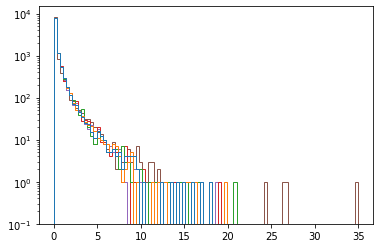

In [6]:
_ = plt.hist([list(in_strengths(randomize_edgeweights2(graph)).values()),
              list(in_strengths(randomize_edgeweights2(graph)).values()),
              list(in_strengths(randomize_edgeweights2(graph)).values()),
              list(in_strengths(randomize_edgeweights2(graph)).values()),
              list(in_strengths(randomize_edgeweights2(graph)).values()),
              list(in_strengths(graph).values()),
             ], bins=100, histtype='step', log=True)

(Note how easy the structure of our code makes this investigation: due to the functions we use to organize our code, making such a plot is trivial.)

An obvious question that will come up when looking at this plot: which color is which histogram? I.e. which are the histograms of the randomized in-strength, and which one is the actual data? This question is a very good one to judge the difference between the histograms: can the difference be large if we cannot tell which curve is which just by looking at it?

This "just eyeball it" might sound like a very cavalier approach, but it can actually be made rigorous: if we plot a lot of randomized histograms using the same color, with some opacity, we will essentially get a distribution of the histograms: the color will be darker where a lot of histograms had datapoints, and lighter were only a few, and there will be no color where none of the histograms had data. Given this "distribution of histograms", if we plot the actual data on top of it, we can easily judge whether it sticks to dark colored high-probability areas, or strays far into the whiteness of low probabilities. To get a quantitative result, we can discretize these histograms, and add up the probabilities of the individual segments, which would give an overall probability (by doing this, we would essentially be calculating an integral using a so-called Monte Carlo method).

Producing such a plot showing different opacities is a bit more complicated, but the following shows an example:

In [7]:
randomized_in_strengths = [
    list(in_strengths(randomize_edgeweights2(graph)).values()),
    list(in_strengths(randomize_edgeweights2(graph)).values()),
    list(in_strengths(randomize_edgeweights2(graph)).values()),
    list(in_strengths(randomize_edgeweights2(graph)).values()),
    list(in_strengths(randomize_edgeweights2(graph)).values()),
]

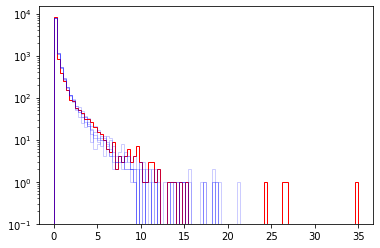

In [8]:
n, bins, patches = plt.hist(list(in_strengths(graph).values()), bins=100, histtype='step', log=True, color='red')

for randomized_instrength_values in randomized_in_strengths:
    _ = plt.hist(randomized_instrength_values, bins=bins, histtype='step', log=True, alpha=0.2, color='b')


Note that the code above calculates the randomized strength values in a seperate notebook cell (this makes experimenting with the colors, opacity, etc. settings of the plot much faster) and that first the actual data is plotted, then the randomized histograms one-by-one, using the same bins. (The parameters of the bins, i.e. where they start and end is returned by .hist(), so we can store it in the 'bins' variable and pass it in the next times we call hist(). The opacity is set with the "alpha" parameter, which the code above only sets for the randomized data.

This plot is quite convincing that the histogram of the actual data matches that of the randomized one pretty well, except for the very largest in-strength values on the right-hand side: all the randomized histograms end at around 20, while the actual data contains some datapoints around 25, as well as one at 35. This difference appears to be significant, but the main body of the histograms are essentially the same.

The main conclusion we can draw from this about our word-association dataset is that there is fairly little (but not zero) correlation between the edge weights and the degrees -- except for a few nodes (those with the highest in-strength), statistically speaking, the in terms of the incoming edges, the edge weights are essentially random. (Note that as we have seen, there is a fairly strong correlation for the outgoing edges, due to the normalization done)